In [47]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

from matplotlib.pyplot import figure

def group_data(lines: [str]) -> [str]:
    result = {}

    for line in lines[1:]:
        parts = line.split(',')
        if parts[0] in result:
            result[parts[0]].append((int(parts[1]), int(parts[2])))
        else:
            result[parts[0]] = [(int(parts[1]), int(parts[2]))]

    return result

geth_evm_evmmax_benchmarks = None
with open("geth-evm-evmmax-benchmarks.csv") as f:
    geth_evm_evmmax_benchmarks = group_data(f.readlines())

go_arith_evmmax_benchmarks = None
with open("go-arith-evmmax-benchmarks.csv") as f:
    go_arith_evmmax_benchmarks = group_data(f.readlines())

go_arith_asm384_benchmarks = None
with open('go-arith-asm384-benchmarks.csv') as f:
    go_arith_asm384_benchmarks = group_data(f.readlines())

geth_evm_asm384_benchmarks = None
with open('geth-evm-asm384-benchmarks.csv') as f:
    geth_evm_asm384_benchmarks = group_data(f.readlines())

def scatterplot_ns_data(name: str, annotate: bool, *args):
    
    x_min_all = min([min([v[0] for v in d]) for (d, _, _) in args])
    x_max_all = max([max([v[0] for v in d]) for (d, _, _) in args])
    y_min_all = min([min([v[1] for v in d]) for (d, _, _) in args])
    y_max_all = max([max([v[1] for v in d]) for (d, _, _) in args])
    span_x = x_max_all - x_min_all
    span_y = y_max_all - y_min_all

    plt.rcParams["figure.figsize"] = (20, 10)
    fig, ax = plt.subplots()
    plt.ylim(0, y_min_all + span_y * 1.2)
    plt.xlim(0, x_min_all + span_x * 1.2)

    for (data, color, label) in args:
        # Map each onto a scatterplot we'll create with Matplotlib
        #ax.scatter(x=x, y=y, c=scale, s=np.abs(scale)*500)
        mulmont_x = [val[0] for val in data]
        mulmont_y = [val[1] for val in data]

        assert len(mulmont_x) == len(mulmont_y)
        span = max(mulmont_y) - min(mulmont_y)

        plt.xlabel("number of limbs")
        plt.ylabel("runtime (ns)")
        
        if annotate:
            for x, y in zip(mulmont_x, mulmont_y):
                ax.annotate(y, (float(x) + 0.2, float(y)))

        ax.plot(mulmont_x, mulmont_y, 'o', color=color, label=label)
    plt.legend(loc="upper left")
    ax.set(title=name)
    plt.show()

## Abstract
We introduce new EVM opcodes for performing modular addition, subtraction and Montgomery multiplication in the EVM.

## Motivation

The EVM already has opcodes `ADDMOD` and `MULMOD` for performing modular arithmetic.  However, these operate on 32-byte words.  This makes it prohibitively-costly to implement modular arithmetic at higher bitwidths.

In addition, many applications perform multiple operations over the same modulus.  Repeatedly passing the same modulus to `ADDMOD`/`SUBMOD` adds overhead and restriction imposed by stack depth limits.

For `MULMOD`, the overhead is heavily dominated by the cost of division in the reduction step.  If an application repeatedly performs operations over the same modulus, the performance of modular multiplication can be greatly improved by expressing values in Montgomery form.  Modular multiplication of values in Montgomery form can make use of Montgomery reduction to replace division in the reduction step with a bitshift and single conditional subtraction.

## Specification

Introduce four opcodes: `ADDMODMAX`, `SUBMODMAX`, `MULMONTMAX`, `SETMODMAX`.

`ADDMODMAX`, `SUBMODMAX` and `MULMONTMAX` perform modular addition, subtraction and Montgomery multiplication respectively.

`SETMODMAX` is used to set the modulus used for arithmetic, and to precompute a modulus-specific parameter used for montgomery reduction.

#### `SETMOD`

`SETMODMAX` takes a stack argument with parameters encoded in the first two bytes: `modSize`, `modOffset`.

If `SETMODMAX` has been previously called in the current call context, halt execution in an exceptional state and return to the calling frame.

If `modSize` is 0 or greater than 7, halt execution in an exceptional state and return to the calling frame.

Memory expansion gas cost is charged to expand memory to `modOffset + modSize * 8`

Assert that the modulus is odd, and return execution to the parent in an exceptional state if not.

`SETMODMAX` computes a per-modulus constant used for Montgomery multiplication ( `modinv = pow(-modulus, -1, 1<<64)` is used for the interleaved Montgomery multiplication algorithms used at lower bit-widths) and associates it with the current call context.

#### Arithmetic Opcodes

`ADDMODMAX` `SUBMODMAX` and `MULMONTMAX` take a single stack element as input.  The first three bytes of the input, are denoted `out_offset`, `x_offset`, `y_offset`.

Each offset refers to a contiguous area of evm memory `[offset*elem_size_bytes:offset*elem_size_bytes + elem_size_bytes]`.  The memory expansion cost for the end of the last offset is charged.  Each number is laid out in memory as a list of 64bit little-endian words.

If `x_offset`, `y_offset` or `out_offset` are greater than 255, halt execution in an exceptional state and return to the calling frame.

If `x` or `y` are greater than or equal to the modulus, halt execution in exceptional state and return to the calling frame.

`ADDMODMAX` computes `(x + y) % mod` and places the result at the memory specified by `out_offset`.

`SUBMODMAX` computes `(x - y) % mod` and places the result at the memory specified by `out_offset`.

`MULMONTMAX` computes `(x * y * pow(R, -1, mod)) % mod` and places it at the memory specified by `out_offset`.


#### Costs

TBD

## Rationale

* choice of little-endian limbs made to match the hardware, removing the need for endianness-swapping individual limbs.
* choice of input encoding as single-bytes which map to "slots" in the memory space was made to reduce bytecode size while providing enough flexibility for users to implement various crypto applications.

### Benchmarks


#### Arithmetic

To estimate performance of the arithmetic opcodes, I developed standalone EVM benchmarks which estimate EVMMAX arithmetic opcode performance at various limb counts using inputs that have worst-case performance.  These benchmarks consist of a setup (placing modulus/input values in memory, calling `SETMOD`), and a large loop which performs 5000 operations for 255 iterations.

Each invocation is of the form `PUSH3 {result offset byte}{x offset byte}{y offset byte} + EVMMAX_ARITH_OP`.

To measure the overhead of `PUSH3`, a separate benchmark which consists of a loop of `PUSH3 000000 POP` with the same number of invocations as the number EVMMAX ops in the EVMMAX benchmark.

The runtime of the `PUSH3_POP` benchmark is subtracted from the `EVMMAX_OP` benchmark and divided by the number of EVMMAX operation invocations to estimate a runtime for a given number of limbs.

The cost of the setup is amortized by the main loop of each benchmark, and the performance numbers are slightly over-estimated as a result.


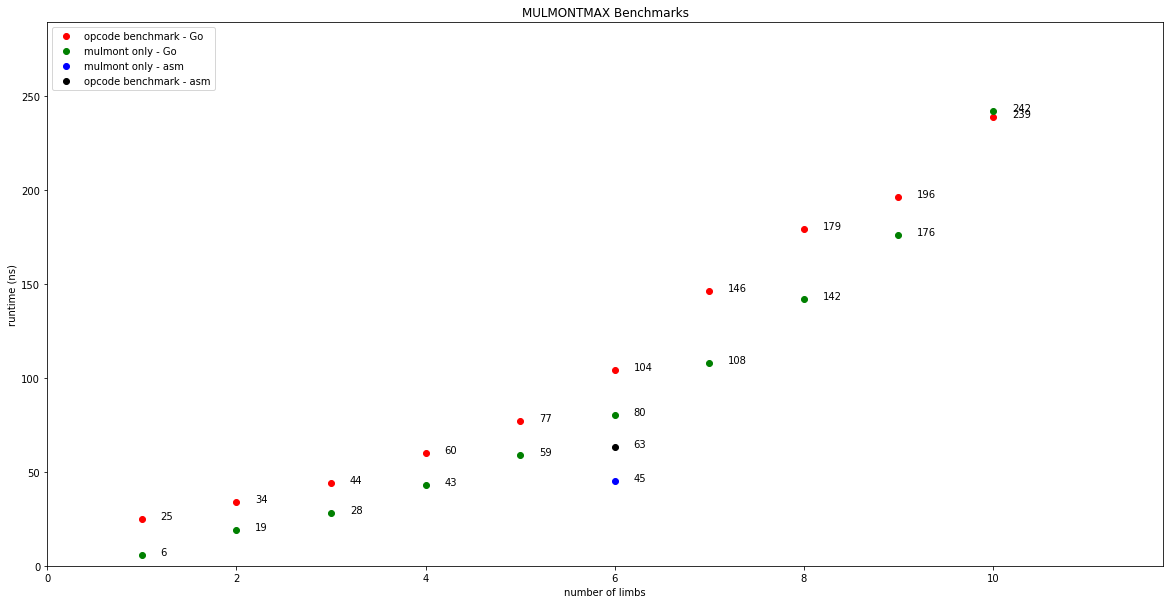

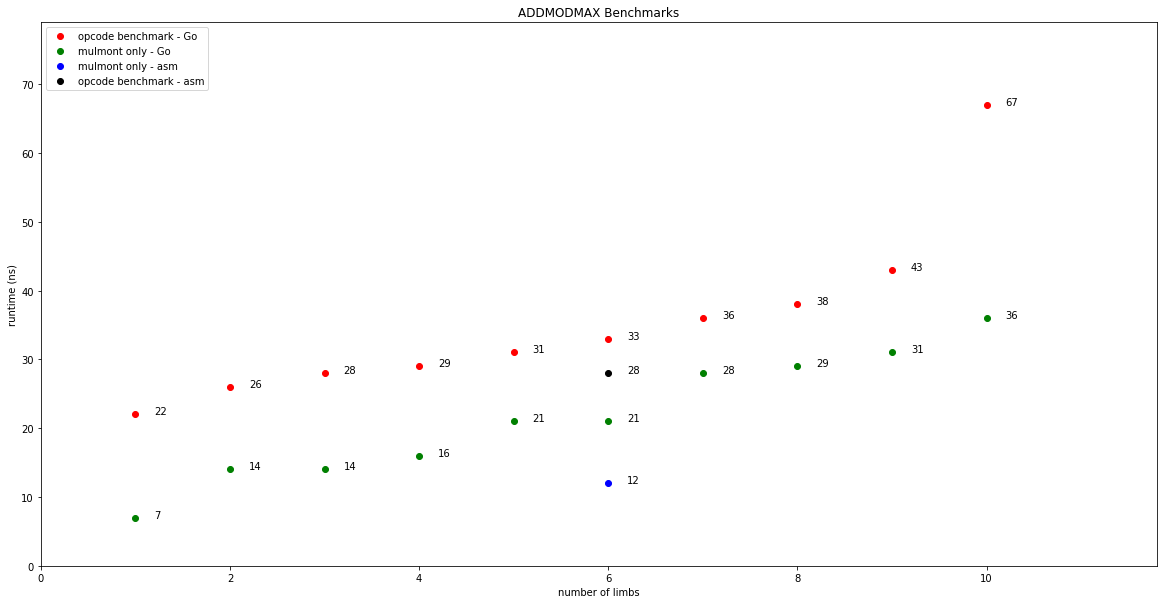

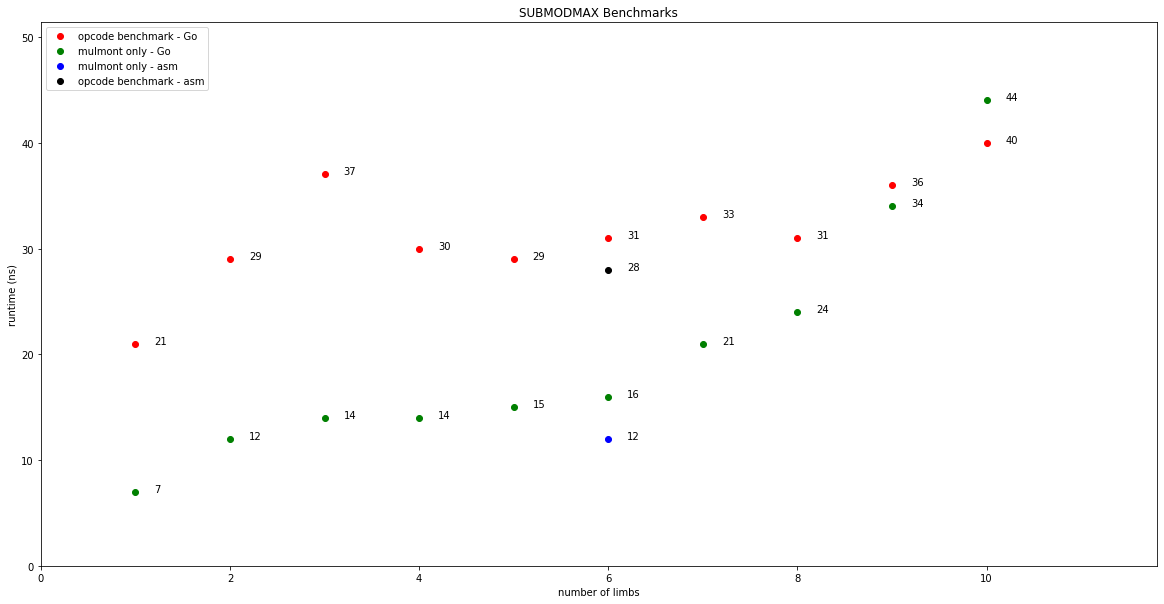

In [48]:
scatterplot_ns_data("MULMONTMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['MULMONTMAX'][:-1], "red", "opcode benchmark - Go" ),
                                                    (go_arith_evmmax_benchmarks['MulMont'][:-2], "green", "mulmont only - Go"),
                                                    (go_arith_asm384_benchmarks['MulMont'], "blue", "mulmont only - asm"),
                                                    (geth_evm_asm384_benchmarks['MULMONTMAX'], "black", "opcode benchmark - asm"))

scatterplot_ns_data("ADDMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['ADDMODMAX'][:-1], "red", "opcode benchmark - Go" ),
                                                    (go_arith_evmmax_benchmarks['AddMod'][:-2], "green", "mulmont only - Go"),
                                                    (go_arith_asm384_benchmarks['AddMod'], "blue", "mulmont only - asm"),
                                                    (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "opcode benchmark - asm"))

scatterplot_ns_data("SUBMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['SUBMODMAX'][:-1], "red", "opcode benchmark - Go" ),
                                                    (go_arith_evmmax_benchmarks['SubMod'][:-2], "green", "mulmont only - Go"),
                                                    (go_arith_asm384_benchmarks['SubMod'], "blue", "mulmont only - asm"),
                                                    (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "opcode benchmark - asm"))


#### `SETMOD`
TODO

## Backwards Compatibility

There are no backwards-compatibility concerns for the changes introduced in this EIP.

## Test Cases
TBD

## Reference Implementation
* TODO link to my geth branch

## Security Considerations

For `MULMONTMAX`, we expect the input to be of the form `(x*R) % modulus` where `R` is chosen as `1 << (limb_count * 64)`.  Because `GCD(N,R) = 1`, multiplication by `R` is isomorphic in `Z/nZ`: any given value is the Montgomery representation of some other value in the field.

* how badly can you slow down evmmax ops by memory thrashing? this is probably not too much of a concern at small limb counts but need some analysis for this